<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# AT&T SPAM detector

## Build a spam detector, that can automatically flag spams as they come based sollely on the sms' content.

In [ ]:
## je travaille sur colab avec les fichiers sur mon drive
colab = True

In [ ]:
## détermination du path
mypath = ''
if colab:
  from sys import path
  from google.colab import drive
  drive.mount('/content/drive')
  path.insert(0,'/content/drive/MyDrive/portfolio/AT&T spam detector/')
  mypath = path[0]
mypath

''

#### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB,MultinomialNB
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


##Definition

From my research:

*    Ham is an E-mail (or sms) that is generally desired and isn't considered spam. Desired because you requested it directly or indirectly. According to the RFC Rules, you can stop receiving it by simply “click to unsubscribe,” and the mail (or sms) stops.
*   Spam is an unsolicited E-mail (or sms), someone send you in bulk.

#### I. Exploring the data

In [ ]:
df_source = pd.read_csv(f'{mypath}src/spam.csv',encoding='latin_1')
display(df_source.describe(include='all'))
print()
display(df_source.head())
print()
df_source.info()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df_source = df_source.rename(columns={"v1":"label","v2":"sms"})

In [ ]:
df_source.drop_duplicates(subset='sms',inplace=True)
df_source.reset_index(drop=True,inplace=True)
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5169 non-null   object
 1   sms         5169 non-null   object
 2   Unnamed: 2  43 non-null     object
 3   Unnamed: 3  10 non-null     object
 4   Unnamed: 4  5 non-null      object
dtypes: object(5)
memory usage: 202.0+ KB




*   'label' takes 2 values: spam and ham to categorize the e-mail
*   'sms' is the content of the email
*   Unnamed:2,Unnamed:3,Unnamed:4 : don't know the meaning, let's see what is their meaning. They are almost empty, so what are the non-null values?

In [ ]:
df_source[~df_source['Unnamed: 4'].isnull()]

,label,sms,Unnamed: 2,Unnamed: 3,Unnamed: 4
277,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
1014,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2168,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe..."
3327,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4360,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""


In [ ]:
df_source[~df_source['Unnamed: 3'].isnull()]

,label,sms,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
277,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
1014,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2086,ham,\CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER...,JUST REALLYNEED 2DOCD.PLEASE DONTPLEASE DONTIG...,"U NO THECD ISV.IMPORTANT TOME 4 2MORO\""""",NaN
2168,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe..."
2984,ham,\SHIT BABE.. THASA BIT MESSED UP.YEH,SHE SHUDVETOLD U. DID URGRAN KNOW?NEWAY,"ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\""""",NaN
3308,ham,Two fundamentals of cool life: \Walk,"like you are the KING\""...! OR \""Walk like yo...","whoever is the KING\""!... Gud nyt""",NaN
3327,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4360,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""
4736,ham,\HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VI...,DEVIOUSBITCH.ANYWAY,"IåÕL CALL U\""""",NaN


In [ ]:
df_source[~df_source['Unnamed: 2'].isnull()]

,label,sms,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
277,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
436,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
660,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
698,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
1014,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1102,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1229,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1343,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN
1384,ham,"Tell you what, if you make a little spreadshee...","I'll come up""",NaN,NaN


So I undestand that the 'Unnamed' columns are for the email exchanges, the responses. So the null values mean something. People won't response in case of spam most of the time. Let's see

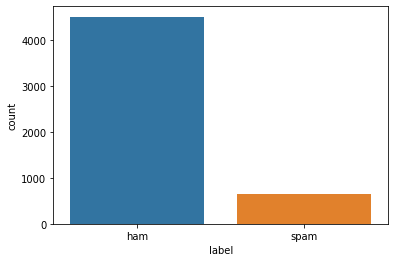

In [ ]:
sns.countplot(data=df_source,x='label')
plt.title('title')

In [ ]:
print(f"{(100*df_source[df_source['label']=='spam']['label'].count()/df_source['label'].count()).round(2)} % of the messages are spams")

12.63 % of the messages are spams


12.63 % of the messages are spams, so we'll have to pay attention during the split between the train and the test set, using 'stratify' in order to preserve the same frequencies

In [ ]:
## Only 5 answers out of 747 spams
print(f"{100*df_source[df_source['label']=='spam']['Unnamed: 2'].count()/df_source[df_source['label']=='spam']['Unnamed: 2'].isnull().count()} % of all spams have no answer")


0.6125574272588055 % of all spams have no answer


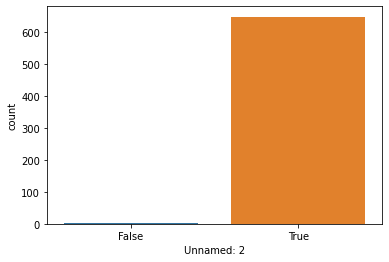

In [ ]:
sns.countplot(data=df_source[df_source['label']=='spam'].isnull()[['Unnamed: 2']],x='Unnamed: 2')

In [ ]:
print(f"{df_source[df_source['label']=='spam']['Unnamed: 2'].count()} answers to spams")
print(f"{df_source[df_source['label']=='spam']['Unnamed: 2'].isnull().sum()} non answers to spams")
print(df_source[df_source['label']=='spam'].count())

4 answers to spams
649 non answers to spams
label         653
sms           653
Unnamed: 2      4
Unnamed: 3      1
Unnamed: 4      0
dtype: int64


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

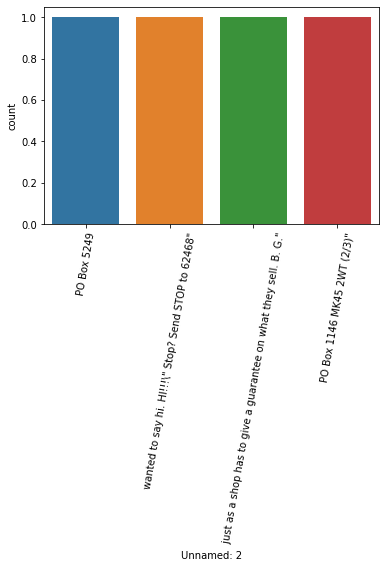

In [ ]:
sns.countplot(data=df_source[df_source['label']=='spam'][['Unnamed: 2']],x='Unnamed: 2')
plt.xticks(rotation=80)

This is just to understand the dataset.Of course we want to predict among incoming mails those who are spams, before having to answer them. The prediction will depend on the content of the sms only.

In [ ]:
df_source = df_source.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1)

display(df_source.describe())
display(df_source.head())
print(df_source.info())

,label,sms
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5169 non-null   object
 1   sms     5169 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB
None


#### II. Preprocessing

In [ ]:
df_classif = df_source
target = 'label'
feature_vars = 'sms_clean'

In [ ]:
df_classif[feature_vars] = df_classif['sms']
df_classif[target]=df_classif[target].map({'ham':0,'spam':1})
df_classif

,label,sms,sms_clean
0,0,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...","Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5164,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...
5165,0,Will Ì_ b going to esplanade fr home?,Will Ì_ b going to esplanade fr home?
5166,0,"Pity, * was in mood for that. So...any other s...","Pity, * was in mood for that. So...any other s..."
5167,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like i'd...


In [ ]:
print(df_classif[feature_vars][4])

Nah I don't think he goes to usf, he lives around here though


In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
# Remove everything that is not alphabetic except single quote, put lowercase
#df_classif[feature_vars] = df_classif[feature_vars].fillna(' ').str.replace(r"[<!--.>/]+", " ")
df_classif[feature_vars] = df_classif[feature_vars].str.replace(r"[^A-Za-z']+", " ")
df_classif[feature_vars] = df_classif[feature_vars].apply(lambda x: x.lower())
df_classif[feature_vars] = df_classif[feature_vars].str.replace("  ", " ")

<ipython-input-21-bc5763944a1c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_classif[feature_vars] = df_classif[feature_vars].str.replace(r"[^A-Za-z']+", " ")


In [ ]:
print(df_classif[feature_vars][4])

nah i don't think he goes to usf he lives around here though


In [ ]:
## tokenization
df_classif[feature_vars] = df_classif[feature_vars].apply(lambda x: nlp(x))
print(df_classif[feature_vars].head())

0    (go, until, jurong, point, crazy, available, o...
1                       (ok, lar, joking, wif, u, oni)
2    (free, entry, in, a, wkly, comp, to, win, fa, ...
3    (u, dun, say, so, early, hor, u, c, already, t...
4    (nah, i, do, n't, think, he, goes, to, usf, he...
Name: sms_clean, dtype: object


In [ ]:
print(df_classif[feature_vars][4])

nah i don't think he goes to usf he lives around here though


In [ ]:
## remove stop-words and tags from html
df_classif[feature_vars] = df_classif[feature_vars].apply(lambda x: [token.lemma_ for token in x if token.is_alpha])
print(df_classif[feature_vars][0])

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'get', 'amore', 'wat']


In [ ]:
print(df_classif[feature_vars][4])

['nah', 'I', 'do', 'think', 'he', 'go', 'to', 'usf', 'he', 'live', 'around', 'here', 'though']


In [ ]:
df_classif[feature_vars]=[' '.join(x) for x in df_classif[feature_vars]]

In [ ]:
display(df_classif)
df_classif[feature_vars][4]

,label,sms,sms_clean
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah I do think he go to usf he live around her...
...,...,...,...
5164,1,This is the 2nd time we have tried 2 contact u...,this be the nd time we have try contact u u ha...
5165,0,Will Ì_ b going to esplanade fr home?,will b go to esplanade fr home
5166,0,"Pity, * was in mood for that. So...any other s...",pity be in mood for that so any other suggestion
5167,0,The guy did some bitching but I acted like i'd...,the guy do some bitching but I act like I be i...


'nah I do think he go to usf he live around here though'

In [ ]:
# Remove punctuation and lowercase
#df_classif[feature_vars] = df_classif[feature_vars].apply(lambda x: x.lower())
#df_classif[feature_vars] = df_classif[feature_vars].str.replace(r"[^A-Za-z']+", " ")
#df_classif[feature_vars] = df_classif[feature_vars].str.replace("  ", " ")
#print(df_classif[feature_vars])

In [ ]:
print(df_classif[feature_vars][4])

nah I do think he go to usf he live around here though


# Let's have a look to spam and ham words according to wordcloud

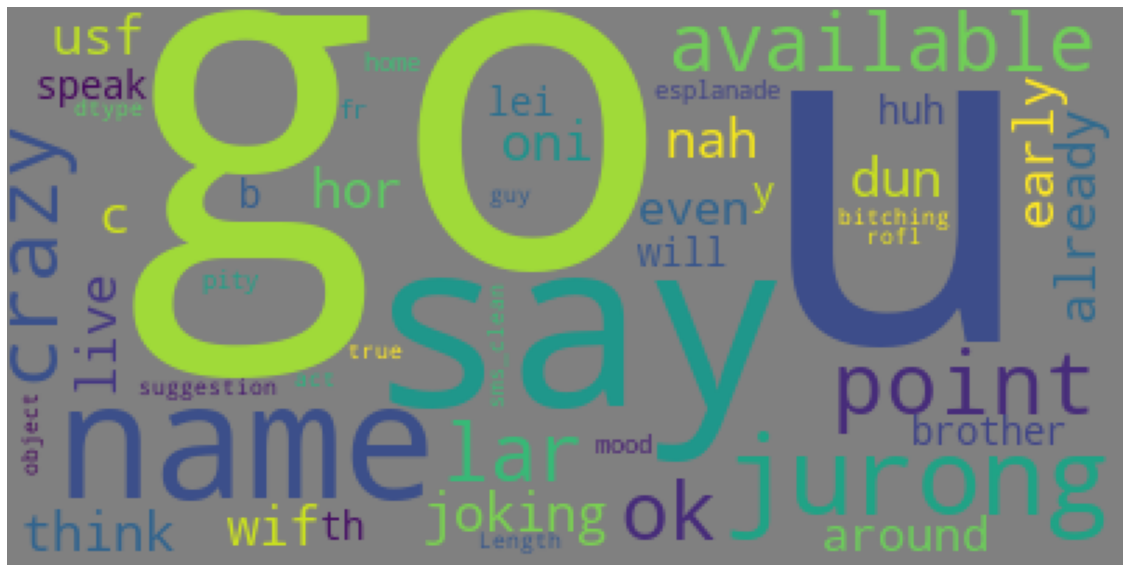

In [ ]:
import wordcloud
## On plot une description pour voir ce que cela donne
wd = wordcloud.WordCloud(background_color="grey", contour_width=1, contour_color='steelblue')#, mask = starwars_mask)

## Generate wordcloud for ham
cloud = wd.generate(str(df_classif[df_classif[target]==0][feature_vars]))
## Show plot
plt.figure(figsize = (20, 20))
plt.imshow(cloud)
plt.axis("off")
plt.show()
print()

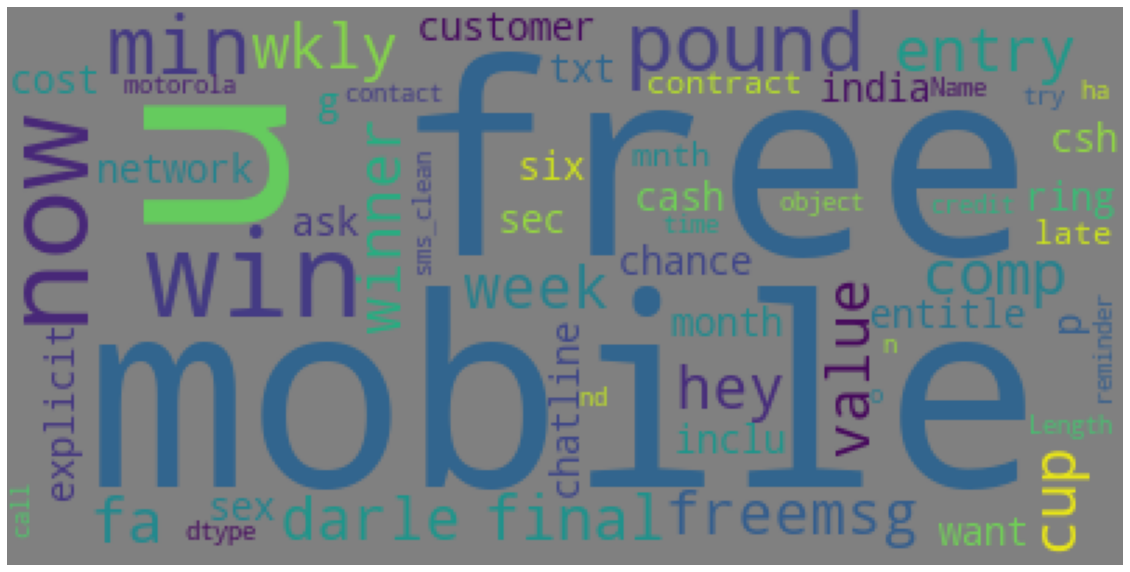

In [ ]:
## Generate wordcloud for spam
cloud = wd.generate(str(df_classif[df_classif[target]==1][feature_vars]))
## Show plot
plt.figure(figsize = (20, 20))
plt.imshow(cloud)
plt.axis("off")
plt.show()
print()

# Encoding the messages

In [ ]:
## Tfidf transformer
vectorizerT = TfidfVectorizer(analyzer='word',stop_words='english', ngram_range=(1, 1))
df_Tfidf = vectorizerT.fit_transform(df_classif[feature_vars])

In [ ]:
vectorizerT.vocabulary_
print(df_Tfidf.shape)
print(df_Tfidf)

(5169, 6316)
  (0, 5994)	0.19914118603531206
  (0, 184)	0.3602223730580947
  (0, 962)	0.3038435610085301
  (0, 727)	0.34373262761599394
  (0, 2932)	0.2908924565701404
  (0, 6159)	0.2514681803505499
  (0, 2238)	0.2007207521967189
  (0, 729)	0.3038435610085301
  (0, 376)	0.2731886294396609
  (0, 1183)	0.2731886294396609
  (0, 4098)	0.2462133051032574
  (0, 2828)	0.3602223730580947
  (1, 3789)	0.5216188170541909
  (1, 6082)	0.41084733052097333
  (1, 2796)	0.5818055755026764
  (1, 2960)	0.38839945292526834
  (1, 3765)	0.2641333337163796
  (2, 256)	0.18714779913873938
  (2, 4383)	0.18076529993663826
  (2, 5724)	0.1389897782492362
  (2, 5162)	0.22737326278102304
  (2, 4337)	0.1881795370687684
  (2, 4424)	0.17995369572733041
  (2, 5461)	0.13244994230128543
  (2, 5133)	0.1783926687312197
  :	:
  (5164, 3579)	0.30396103380703887
  (5164, 5694)	0.2406455819989314
  (5164, 3567)	0.32400282332118113
  (5164, 5554)	0.20414692235620727
  (5164, 4150)	0.3110343847075002
  (5164, 970)	0.24750814735663

In [ ]:
vectorizerT.vocabulary_

{'jurong': 2828,
 'point': 4098,
 'crazy': 1183,
 'available': 376,
 'bugis': 729,
 'great': 2238,
 'world': 6159,
 'la': 2932,
 'buffet': 727,
 'cine': 962,
 'amore': 184,
 'wat': 5994,
 'ok': 3765,
 'lar': 2960,
 'joking': 2796,
 'wif': 6082,
 'oni': 3789,
 'free': 2004,
 'entry': 1688,
 'wkly': 6127,
 'comp': 1059,
 'win': 6094,
 'fa': 1803,
 'cup': 1235,
 'final': 1893,
 'tkts': 5573,
 'st': 5133,
 'text': 5461,
 'receive': 4424,
 'question': 4337,
 'std': 5162,
 'txt': 5724,
 'rate': 4383,
 'apply': 256,
 'dun': 1574,
 'say': 4691,
 'early': 1591,
 'hor': 2465,
 'nah': 3547,
 'think': 5506,
 'usf': 5845,
 'live': 3071,
 'freemsg': 2010,
 'hey': 2397,
 'darle': 1283,
 'week': 6030,
 'word': 6152,
 'like': 3040,
 'fun': 2055,
 'tb': 5403,
 'xxx': 6224,
 'chgs': 920,
 'send': 4761,
 'rcv': 4393,
 'brother': 703,
 'speak': 5065,
 'treat': 5670,
 'aid': 123,
 'patent': 3939,
 'request': 4505,
 'melle': 3317,
 'oru': 3837,
 'minnaminunginte': 3372,
 'nurungu': 3713,
 'vettam': 5894,
 's

In [ ]:
vectorizerT.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aah',
 'aaniye',
 'aaooooright',
 'aathi',
 'ab',
 'abbey',
 'abdoman',
 'abeg',
 'abel',
 'aberdeen',
 'abi',
 'ability',
 'abiola',
 'abj',
 'able',
 'abnormally',
 'abouta',
 'abroad',
 'absence',
 'absolutely',
 'absolutly',
 'abstract',
 'abt',
 'abta',
 'aburo',
 'abuse',
 'abuser',
 'ac',
 'academic',
 'acc',
 'accent',
 'accenture',
 'accept',
 'access',
 'accessible',
 'accidant',
 'accident',
 'accidentally',
 'accommodation',
 'accommodationvoucher',
 'accomodate',
 'accomodation',
 'accordin',
 'accordingly',
 'account',
 'accumulation',
 'achan',
 'ache',
 'achieve',
 'acid',
 'acknowledgement',
 'acl',
 'acnt',
 'aco',
 'act',
 'actin',
 'action',
 'activ',
 'activate',
 'active',
 'activity',
 'actor',
 'actual',
 'actually',
 'ad',
 'adam',
 'add',
 'addamsfa',
 'addict',
 'addie',
 'address',
 'adewale',
 'adi',
 'adjustable',
 'admin',
 'administrator',
 'admirer',
 'admission',
 'admit',
 'adore',
 'adp',
 'adress',
 'adrian',
 'adsense',
 'adult',
 'advance

In [ ]:
# X is a generator. We can transform that as an array
features_array = df_Tfidf.toarray()
print('shape---',features_array.shape)
print()
features_array

shape--- (5169, 6316)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#Spliting the data

In [ ]:
X, X_test, y, y_test = train_test_split(df_Tfidf,df_source[target], random_state=7,stratify=df_source[target])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7)

print(df_Tfidf.shape,df_source[target].shape)
print()
print(X_test.shape,y_test.shape)
print()
print(X_train.shape,y_train.shape)
print()
print(X_val.shape,y_val.shape)

(5169, 6316) (5169,)

(1293, 6316) (1293,)

(2907, 6316) (2907,)

(969, 6316) (969,)


# Training LogisticRegression, SVM, ComplementNB

Accuracy: 0.954369682907966

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

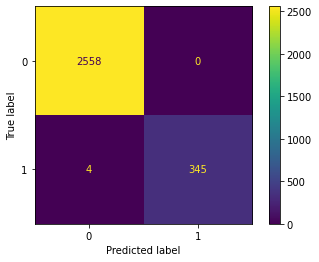

In [ ]:
svc = svm.SVC()
svc.fit(X_train,y_train)
y_svc = svc.predict(X_val)
print("Accuracy: {}".format(svc.score(X_test,y_test)))
print()
print(y_svc)
print()
y_svc.shape
print(classification_report(y_val,y_svc))
#print(confusion_matrix(X_train,y_train))
print()
ConfusionMatrixDisplay.from_estimator(svc,X_train,y_train)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       828
           1       0.99      0.56      0.71       141

    accuracy                           0.93       969
   macro avg       0.96      0.78      0.84       969
weighted avg       0.94      0.93      0.93       969





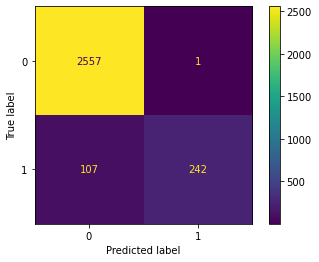

In [ ]:
logReg = LogisticRegression()
logReg.fit(X_train,y_train)
y_logReg = logReg.predict(X_val)
print(classification_report(y_val,y_logReg))
print()
#print(confusion_matrix(X_train,y_train))
print()
ConfusionMatrixDisplay.from_estimator(logReg,X_train,y_train)

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       828
           1       0.64      0.89      0.74       141

    accuracy                           0.91       969
   macro avg       0.81      0.90      0.84       969
weighted avg       0.93      0.91      0.92       969





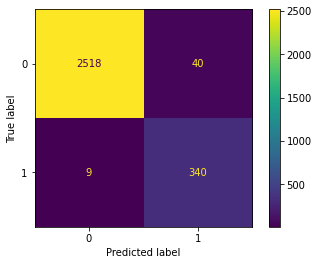

In [ ]:
cnb = ComplementNB()
cnb.fit(X_train,y_train)
y_cnb = cnb.predict(X_val)
print(classification_report(y_val,y_cnb))
print()
#print(confusion_matrix(X_train,y_train))
print()
ConfusionMatrixDisplay.from_estimator(cnb,X_train,y_train)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       828
           1       1.00      0.62      0.77       141

    accuracy                           0.95       969
   macro avg       0.97      0.81      0.87       969
weighted avg       0.95      0.95      0.94       969





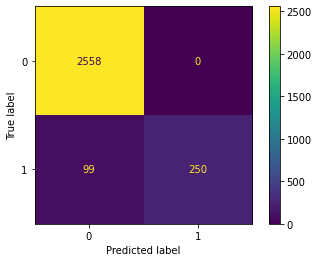

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_mnb = mnb.predict(X_val)
print(classification_report(y_val,y_mnb))
print()
#print(confusion_matrix(X_train,y_train))
print()
ConfusionMatrixDisplay.from_estimator(mnb,X_train,y_train)

In [ ]:
## All The results gathered bellow
print()
print("SVM")
print(classification_report(y_val,y_svc))
print()
print("MultinomialNB")
print(classification_report(y_val,y_mnb))
print()
print("LogisticRegression")
print(classification_report(y_val,y_logReg))
print()
print("ComplementNB")
print(classification_report(y_val,y_cnb))


SVM
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       828
           1       1.00      0.75      0.86       141

    accuracy                           0.96       969
   macro avg       0.98      0.88      0.92       969
weighted avg       0.97      0.96      0.96       969


MultinomialNB
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       828
           1       1.00      0.62      0.77       141

    accuracy                           0.95       969
   macro avg       0.97      0.81      0.87       969
weighted avg       0.95      0.95      0.94       969


LogisticRegression
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       828
           1       0.99      0.56      0.71       141

    accuracy                           0.93       969
   macro avg       0.96      0.78      0.84       969
weighted avg       0.94      0.93 

# A pre-trained deep learning model

## Classifying text with DistilBERT and Tensorflow
you'll find the link [here](https://colab.research.google.com/github/peterbayerle/huggingface_notebook/blob/main/distilbert_tf.ipynb)

In [ ]:
%%capture
!python3 -m venv venv
!source venv/bin/activate
!pip install tensorflow transformers
!pip install tensorflow
!pip install tensorflow_text

In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle

This notebook explores binary text classification using `TFDistilBertForSequenceClassification` from the 🤗Transformers library.

This notebook is broken up into 5 sections:
1. Preprocessing the data
2. Fine-tuning the model
3. Testing the model
4. Using the fine-tuned model to predict new samples
5. Saving and loading the model for future use



Let's start off by taking a look at our dataset. In this example we consider a small corpus of 10 Yelp reviews: 5 positive (class 1) and 5 negative (class 0). BERT (and its variants like DistilBERT) can be a [great tool to use when you have a shortage of training data](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) ... that said, don't expect great results with just 10 reviews! Interchanging `x` and `y` with your own dataset is recommended 🙂

In [ ]:
x = df_classif[feature_vars].values.tolist()

y = df_classif[target].values.tolist()

# 1. Preprocessing the data

Since we are using the [DisitlBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model, the first preprocessing step is to convert each review string in our dataset into a tuple containing the review's [input ids](https://huggingface.co/transformers/glossary.html#input-ids) and [attention masks](https://huggingface.co/transformers/glossary.html#attention-mask) (click the links to learn what these mean!). Luckily, these can easily be computed using the [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer) from 🤗Transformers.

Below is an example usage of this tokenizer on the first review. Here `MAX_LEN` specifies the length of each tokenized review. If a tokenized review is shorter than `MAX_LEN`, then it is padded with zeros. If a tokenized review is greater than `MAX_LEN`, then it is truncated (this is why we have `truncation=True` and `padding=True`).

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 20

review = x[0]

tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tkzr(review, max_length=MAX_LEN, truncation=True, padding=True)

print(f'review: \'{review}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')


review: 'go until jurong point crazy available only in bugis n great world la e buffet cine there get amore wat'
input ids: [101, 2175, 2127, 18414, 17583, 2391, 4689, 2800, 2069, 1999, 11829, 2483, 1050, 2307, 2088, 2474, 1041, 28305, 25022, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Now we must apply this transformation to each review in our corpus. To do this we define a function `construct_encodings`, which maps the tokenizer to each review and aggregates them in `encodings`:

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(x, tkzr, max_len=MAX_LEN)

The first stage of preprocessing is done! The second stage is converting our `encodings` and `y` (which holds the classes of the reviews) into a [Tensorflow Dataset object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Below is a function to do this:



In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        ## this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, y)

The third and final preprocessing step is to create [training](https://developers.google.com/machine-learning/glossary#training-set) and [test sets](https://developers.google.com/machine-learning/glossary#test-set):

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(x) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(x))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

Our data is finally ready. Now we can do the fun part: model fitting! 🙌 🙌 🙌

# 2. Fine-tuning the model

Fine-tuning the model is as easy as instantiating a model instance, [optimizer](https://developers.google.com/machine-learning/glossary#optimizer), and [loss](https://developers.google.com/machine-learning/glossary#loss), and then compiling/fitting:

In [ ]:
#N_EPOCHS = 2
N_EPOCHS = 1

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss=loss, metrics=['classification_report'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

2068/2068 [==============================] - 1400s 667ms/step - loss: 0.1195 - accuracy: 0.9589


## 3. Testing the model

Now we can use our test set to evaluate the performance of the model. Don't expect great results from such a small training set! 😅

In [ ]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

517/517 [==============================] - 50s 93ms/step - loss: 0.0434 - accuracy: 0.9855
{'loss': 0.04340873658657074, 'accuracy': 0.9854932427406311}


# 4. Using the fine-tuned model to predict new samples

Now that we've trained the model, we can use it to predict new samples. Below is a function whose output is a classifier we can use for predictions:

In [ ]:
def create_predictor(model, model_name, max_len):
  tkzr = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tkzr, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      return preds[0][0]

  return predict_proba

clf = create_predictor(model, MODEL_NAME, MAX_LEN)


In [ ]:
print(clf("Always eat at Jo's"))

1/1 [==============================] - 2s 2s/step
0.9974132


## 5. Saving and loading the model for future use

We use the built-in [save](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.save_pretrained) and [load](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.from_pretrained) methods from 🤗Transformers to serialize the model and restore it for future use:


In [ ]:
model.save_pretrained(f'{mypath}src/model/clf')
with open(f'{mypath}src/model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

We save `MODEL_NAME` and `MAX_LEN` for tokenizing/formatting down the line. Below we see how to reload the model for future use:

In [ ]:
new_model = TFDistilBertForSequenceClassification.from_pretrained(f'{mypath}src/model/clf')
model_name, max_len = pickle.load(open(f'{mypath}src/model/info.pkl', 'rb'))

clf = create_predictor(new_model, model_name, max_len)
print(clf("Always eat at Jo's"))

Some layers from the model checkpoint at /content/drive/MyDrive/AT&T spam detector/src/model/clf were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/AT&T spam detector/src/model/clf and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

1/1 [==============================] - 2s 2s/step
0.9974132


Unsuprisingly, we get the same prediction as before!

In [ ]:
tresh_size=round(df_classif.shape[0]*0.75)
df_test = df_classif.iloc[tresh_size:,:].reset_index(drop=True)
print(df_test[df_test[target]==0]['sms'].shape)
print(df_test[df_test[target]==0][target].shape)
df_test.head()

(1144,)
(1144,)


,label,sms,sms_clean
0,0,\Its Ur luck to Love someone. Its Ur fortune t...,its ur luck to love someone its ur fortune to ...
1,0,Hi baby ive just got back from work and i was ...,hi baby I ve just get back from work and I be ...
2,1,FreeMsg Today's the day if you are ready! I'm ...,freemsg today the day if you be ready I horny ...
3,0,Is it your yahoo boys that bring in the perf? ...,be it your yahoo boy that bring in the perf or...
4,0,No need to say anything to me. I know i am an ...,no need to say anything to I I know I be an ou...


In [ ]:
for sms in df_test[df_test[target]==0]['sms'].tolist()[:5]:
  print(clf(sms))

1/1 [==============================] - 2s 2s/step
0.9961094
1/1 [==============================] - 0s 60ms/step
0.9970343
1/1 [==============================] - 0s 61ms/step
0.99626887
1/1 [==============================] - 0s 55ms/step
0.99727803
1/1 [==============================] - 0s 56ms/step
0.99680066


In [ ]:
for sms in df_test[df_test[target]==1]['sms'].tolist()[:5]:
  print(clf(sms))

1/1 [==============================] - 0s 73ms/step
0.010690843
1/1 [==============================] - 0s 68ms/step
0.8217835
1/1 [==============================] - 0s 65ms/step
0.005651445
1/1 [==============================] - 0s 65ms/step
0.0050770324
1/1 [==============================] - 0s 77ms/step
0.0051613124


The DistilBERT pre-trained model gives us better results than the others.